In [1]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective,helpers ,instance# Difference a. We are using ComplexDynamicsProblem
import matplotlib.pyplot as plt
import json
import os
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm
import scipy 
import pickle as pckl
from scipy.stats import linregress
import dwave_networkx as dnx

In [2]:
import matplotlib.font_manager as fm
fm.fontManager.addfont("../times.ttf")  #path to the times.ttf file on your computer
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman'],
})

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'font.size': 12})

In [3]:
import sys
print(sys.path[1])

/usr/lib/python311.zip


In [4]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


# List instances

In [5]:
path = f'../data/instances/'
for item in os.listdir(path):
    if item[-5:] == '.pckl':    
        with open(os.path.join(path, item),'rb') as f:
            print(f"---------- System {item} ------------")
            data = pckl.load(f)
            print(data['H'])


---------- System 10.pckl ------------
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.57079633]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.  

# Analyze

In [6]:
def load_data(raw = False,topology='6.4',system=1):
    path = f'../data/results/hessian/{system}/'

    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            qpu_access_time = s.info['timing']['qpu_access_time']
            s = s.to_pandas_dataframe()
            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            s['energy'] = abs(round(s['energy'],10))
            s['access_time'] = (qpu_access_time / s['num_occurrences'].sum()) * s['num_occurrences'] * 1e-3
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [7]:
topology='6.4'
dfs_all = load_data(topology=topology,system=4)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram


In [8]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_28905/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.3800e+00 6.2840e+00 1.4728e+01 2.0188e+01 2.1392e+01 1.6860e+01
 1.0292e+01 5.3280e+00 2.2360e+00 9.0000e-01 2.5600e-01 1.0800e-01
 2.4000e-02 1.2000e-02 1.2000e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
/tmp/ipykernel_28905/4200412015.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.3800e+00 2.1012e+01 4.1580e+01 2.7152e+01 7.5640e+00 1.1560e+00
 1.3200e-01 2.4000e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100


systemid  precision  timepoints  energy
6.4       2          2           0          7.312000
                                 1         46.400000
                                 2         37.168000
                                 3          8.264000
                                 4          0.768000
                                 5          0.072000
                                 6          0.016000
                     3           0          1.380000
                                 1         21.012000
                                 2         41.580000
                                 3         27.152000
                                 4          7.564000
                                 5          1.156000
                                 6          0.132000
                                 7          0.024000
                     4           0          0.303846
                                 1          8.938462
                                 2         30.226923
      

# Interpret results

[(2, 5)]
(4, 4)


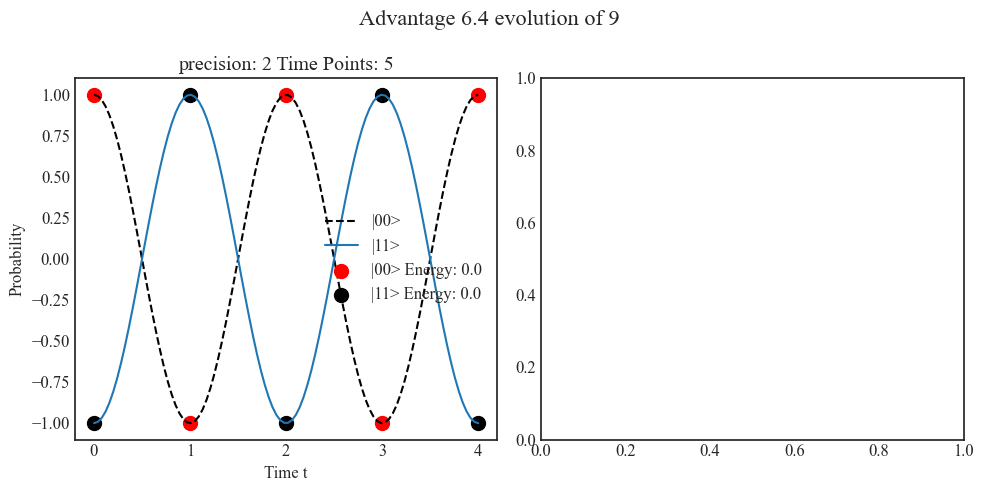

In [9]:
import qutip as qp

system = 9

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
tp_pairs = [(2,5)]
print(tp_pairs)
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.basis(2**dim, 1)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")

    ax.legend()
fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



[(2, 5)]
[[0.+0.j         0.-1.57079633j]
 [0.+1.57079633j 0.+0.j        ]]
(2, 2)
[[2.35619449+0.j         0.        +0.78539816j]
 [0.        -0.78539816j 2.35619449+0.j        ]]
(2, 2)
[[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 1.57079633+0.j 0.        +0.j]
 [0.        +0.j 1.57079633+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]]
(4, 4)


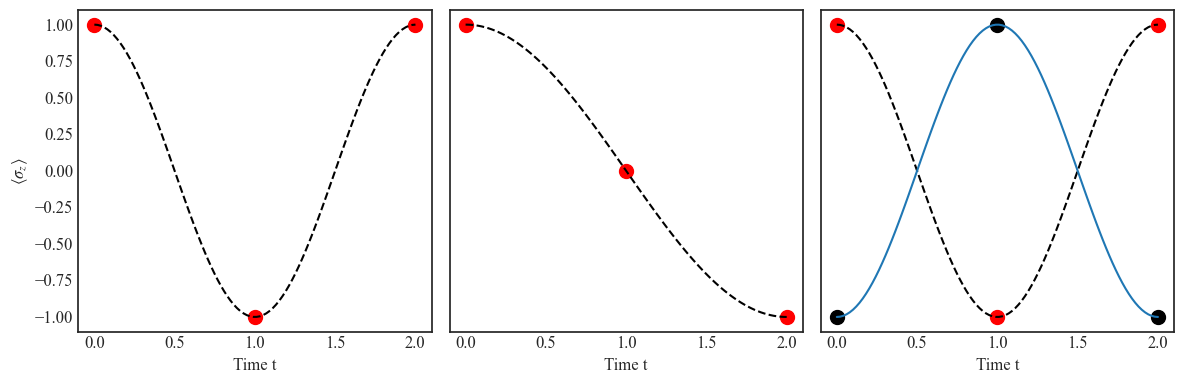

In [10]:
import qutip as qp

from matplotlib.legend_handler import HandlerTuple


system = 1

timepoints = 3

tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
tp_pairs = [(2,5)]
print(tp_pairs)
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)


system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}






for i,(precision, system) in enumerate(zip([2,3,2],[1,3,9])):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    print(H)
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2


    dfs_data_raw = load_data(raw=True,system=system)

    print(H.shape)


    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.Qobj(PSI0)
    #psi_0 = (qp.basis(2, 0) + qp.basis(2, 1)).unit()
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00, P_11]).expect
    
    ax=axes[i]
    ax.plot(times, baseline[0], "k--",label="QuTiP: 1st qubit")
    if dim == 2:
        ax.plot(times, baseline[1],label="QuTiP: 2nd qubit")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(1)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"QPU: 1st qubit", alpha=1.0, s=100)
        if dim == 2:
            ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"QPU: 2nd qubit", alpha=1.0, s=100)

    ax.set_xlabel("Time t", fontsize=12)
axes[0].set_ylabel(r"$\langle \sigma_z \rangle$",fontsize = 12)


   # ax.legend(fontsize=15)
plt.tight_layout()
plt.savefig(f'../plots/system{topology}_dynamic_2_3_9.pdf' ,bbox_inches='tight')
plt.show()



In [11]:
psi_0

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

(4, 4)
(4, 4)
(4, 4)
(4, 4)


IndexError: index 3 is out of bounds for axis 0 with size 3

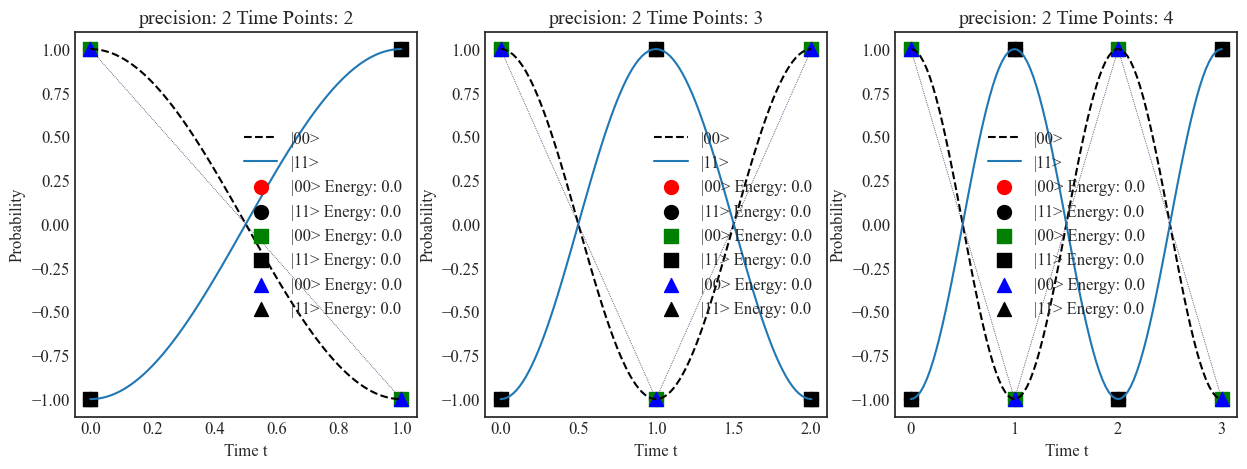

In [12]:
import qutip as qp

system = 9

dfs_data_raw = load_data(raw=True,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}




for i, (precision,timepoints) in enumerate(tp_pairs):
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    #H = instance['H']

    #baseline 
    # Projectors on |0..0⟩ and |1..1⟩
    #P_00 = qp.tensor([qp.basis(2, 0)]*dim).proj()
    #P_11 = qp.tensor([qp.basis(2, 1)]*dim).proj()

    P_00 = qp.tensor([qp.sigmaz()]+ [qp.qeye(2)]*(dim-1))
    P_11 = qp.tensor([qp.qeye(2)]*(dim-1) + [qp.sigmaz()])

    H_qp = qp.Qobj(H,dims=[[2]*dim,[2]*dim])

    psi_0 = qp.Qobj(PSI0)
    psi_0.dims = [[2]*dim, [1]]  # Naprawa błędu wymiarów

    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[P_00,P_11]).expect
    ax = axes[i]

    ax.plot(times, baseline[0], "k--",label="|00>")
    ax.plot(times, baseline[1],label="|11>")


    problem = inst.problem
    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:value for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)

        expect_00 = [(state.conj() @ P_00.full() @ state).real for state in vec]
        expect_11 = [(state.conj() @ P_11.full() @ state).real for state in vec]

        ax.scatter(problem.times, expect_00, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"|00> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.plot(problem.times, expect_00, alpha=0.5, color=colors[j % len(colors)], linestyle=':', linewidth=0.5)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"Probability", fontsize=12)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
#fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
plt.tight_layout()
#plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



In [ ]:
helpers.return_tts(0.006,0.18)

137.74022454944586

# Performance comparison Velox vs D-Wave

---------- System 2 ----------
    system      source  precision  num_var  timepoints   runtime  \
0        2       VELOX          2     16.0           2  0.007444   
1        2       VELOX          2     24.0           3  0.007641   
2        2       VELOX          2     32.0           4  0.007813   
3        2       VELOX          2     40.0           5  0.008050   
4        2   Advantage          2     16.0           2  0.295172   
5        2   Advantage          2     24.0           3  0.301209   
6        2   Advantage          2     32.0           4  0.312010   
7        2   Advantage          2     40.0           5  0.302432   
8        2  Advantage2          2     16.0           2  0.344150   
9        2  Advantage2          2     24.0           3  0.348277   
10       2  Advantage2          2     32.0           4  0.349925   
11       2  Advantage2          2     40.0           5  0.351311   

    success_prob      tts99  
0       1.000000   0.007444  
1       1.000000   0.007

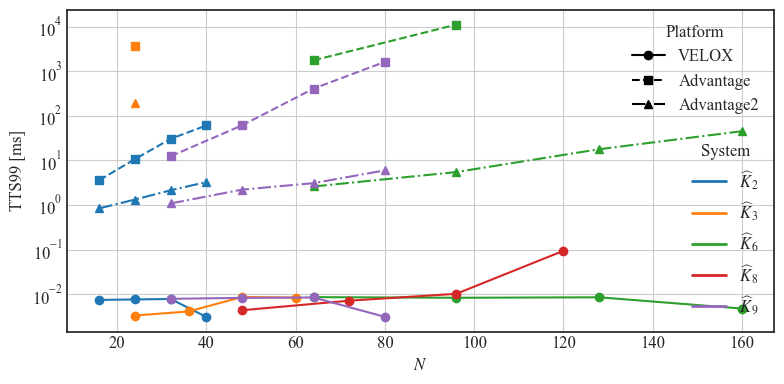

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
systems = [2,3,6,8,9]
ALL_dfs = []

native_systems = [1,2,5,6,7,9]

import matplotlib.font_manager as fm
fm.fontManager.addfont("../times.ttf")  #path to the times.ttf file on your computer
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman'],
})
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'stix'
from matplotlib.lines import Line2D
for idx, system in enumerate(systems):
    df1_filtered = helpers.get_velox_success_rates(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='6.4')
    df3_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='1.4')

    # Dodajemy identyfikator źródła
    df1_filtered['source'] = 'VELOX'
    df2_filtered['source'] = 'Advantage'
    df3_filtered['source'] = 'Advantage2'

    # Łączymy oba DataFrame'y
    combined = pd.concat([df1_filtered,df2_filtered,df3_filtered])
    # Reset indeksu do kolumn
    combined = combined.reset_index()
    combined =combined[combined.timepoints.isin([2,3,4,5])]
    # Tworzymy etykiety X
    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    #print(combined[['system','num_var','precision','timepoints','source','runtime','success_prob','tts99']].to_latex(escape=True))
    df = combined.copy()
    
    velox = df[df['source'] == 'VELOX'].dropna(subset=['num_var', 'tts99'])
    advantage1 = df[df['source'] == 'Advantage'].dropna(subset=['num_var', 'tts99'])
    advantage2 = df[df['source'] == 'Advantage2'].dropna(subset=['num_var', 'tts99'])
    print(f'---------- System {system} ----------')
    combined = combined[['system','source','precision','num_var','timepoints','runtime','success_prob','tts99']]
    print(combined)
    color = colors[idx % len(colors)]
    
    ax.plot(velox['num_var'], velox['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(advantage1['num_var'], advantage1['tts99'],
            marker='s', linestyle='--', color=color)
    
    ax.plot(advantage2['num_var'], advantage2['tts99'],
            marker='^', linestyle='dashdot', color=color)
    
    ALL_dfs.append(combined)
all_system_dfs = pd.concat(ALL_dfs,axis=0)
native_system_df = all_system_dfs[all_system_dfs.system.isin(native_systems)].groupby(['source','precision','num_var','timepoints']).mean().reset_index().drop(labels=['system'],axis=1)
sources = ['Advantage', 'Advantage2']



# Legenda 1: styl/metoda
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', label='VELOX'),
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='Advantage'),
    Line2D([0], [0], color='black', linestyle='dashdot', marker='^', label='Advantage2')
]



legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')

# Legenda 2: kolory/systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=fr'$\widehat K_{s}$') for idx, s in enumerate(systems)
]

legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)  # dodaj pierwszą legendę z powrotem do osi

# Oś, tytuł itd.
ax.set_xlabel(r'$N$')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
plt.tight_layout()
plt.savefig(f'../plots/tta_overview.pdf' ,bbox_inches='tight')
plt.show()



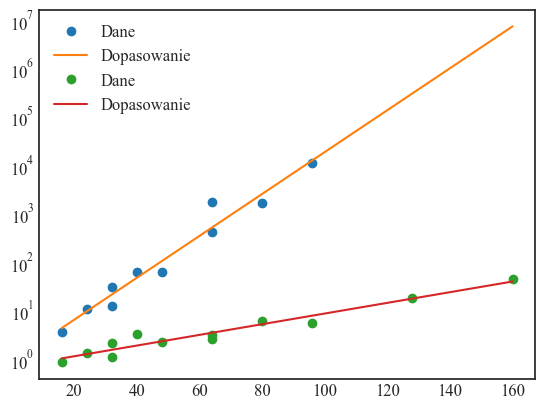

In [ ]:
sources = ['Advantage', 'Advantage2']
D =[]
r_TTS99=[]

for source in sources:
    # Dane (przykład)
    native_system_df_filtered = native_system_df[native_system_df.source == source]
    num_var = np.array(native_system_df_filtered['num_var'])         # liczba zmiennych
    TTS99 = np.array(native_system_df_filtered['tts99'])           # czasy TTS99

    # Filtrowanie tylko wartości skończonych
    mask = np.isfinite(TTS99)
    num_var_clean = num_var[mask]
    TTS99_clean = TTS99[mask]

    # Logarytmowanie
    log_TTS99 = np.log(TTS99_clean)

    # Regresja liniowa
    slope, intercept, r_value, p_value, std_err = linregress(num_var_clean, log_TTS99)

    # Współczynniki
    r_TTS99 = slope
    D =np.exp(intercept)
    t = D * np.exp(r_TTS99 * num_var)
    # Przewidywane wartości
    TTS99_fit = D * np.exp(r_TTS99 * num_var)

    # Wykres
    for system in native_systems:
        plt.semilogy(num_var, np.array(all_system_dfs[all_system_dfs.system.isin(native_system_df)]['tts99']), 'o', label='Dane')
    plt.semilogy(num_var, TTS99_fit, '-', label='Dopasowanie')

plt.legend()

In [20]:
np.array(all_system_dfs[all_system_dfs.system.isin(native_systems)]['tts99'])

array([7.44399412e-03, 7.64120540e-03, 7.81349818e-03, 3.08769414e-03,
       3.61657204e+00, 1.07530030e+01, 3.05695177e+01, 6.09885749e+01,
       8.42484354e-01, 1.32907131e+00, 2.14300013e+00, 3.28361171e+00,
       8.60324634e-03, 8.31861201e-03, 8.52508835e-03, 4.76945890e-03,
       1.75949490e+03, 1.11372214e+04,            inf,            inf,
       2.60658235e+00, 5.49467835e+00, 1.78725199e+01, 4.53056788e+01,
       7.88593549e-03, 8.27562804e-03, 8.45655127e-03, 3.10416597e-03,
       1.24621625e+01, 6.13532626e+01, 4.08691924e+02, 1.62878798e+03,
       1.08688867e+00, 2.21883546e+00, 3.09943236e+00, 5.98719208e+00])

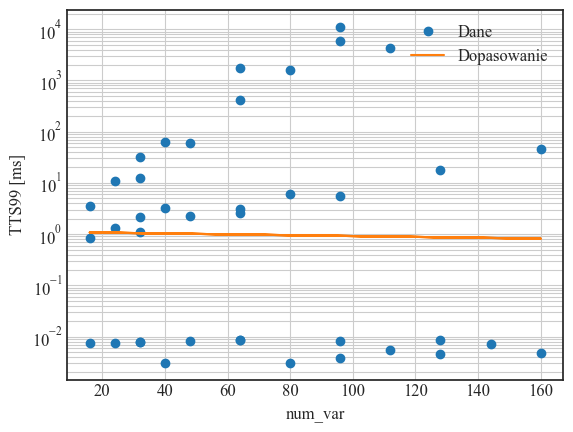

In [ ]:
import matplotlib.pyplot as plt


plt.xlabel('num_var')
plt.ylabel('TTS99 [ms]')
plt.legend()
plt.grid(True, which='both')
plt.show()

        source  precision  num_var  timepoints   runtime  success_prob  \
0    Advantage          2     16.0           2  0.295616      0.332727   
1    Advantage          2     24.0           3  0.298667      0.158312   
2    Advantage          2     32.0           4  0.310280      0.053051   
3    Advantage          2     40.0           5  0.305133      0.030492   
4   Advantage2          2     16.0           2  0.343494      0.852343   
5   Advantage2          2     24.0           3  0.348264      0.709760   
6   Advantage2          2     32.0           4  0.351486      0.562829   
7   Advantage2          2     40.0           5  0.352252      0.417380   
8        VELOX          2     16.0           2  0.007472      1.000000   
9        VELOX          2     24.0           3  0.007649      1.000000   
10       VELOX          2     32.0           4  0.007843      1.000000   
11       VELOX          2     40.0           5  0.008154      0.999997   

        tts99  
0    3.378629  
1    

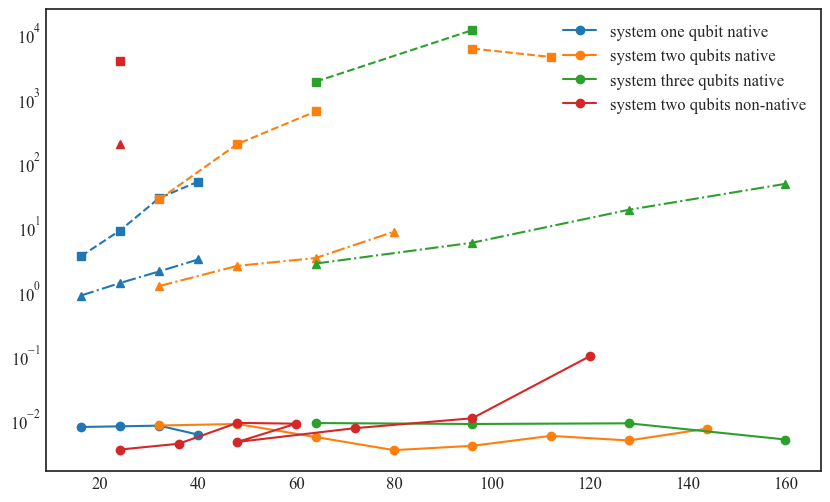

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for idx, (df,system) in enumerate(zip([one_qubit_df, two_qubit_df, three_qubit_df, two_qubit_connected],['one qubit native','two qubits native','three qubits native', 'two qubits non-native'])):
    velox = df[df['source'] == 'VELOX'].dropna(subset=['num_var', 'tts99'])
    advantage1 = df[df['source'] == 'Advantage'].dropna(subset=['num_var', 'tts99'])
    advantage2 = df[df['source'] == 'Advantage2'].dropna(subset=['num_var', 'tts99'])
    color = colors[idx % len(colors)]
    print(df)
    ax.plot(velox['num_var'], velox['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(advantage1['num_var'], advantage1['tts99'],
            marker='s', linestyle='--', color=color)
    
    ax.plot(advantage2['num_var'], advantage2['tts99'],
            marker='^', linestyle='dashdot', color=color)
ax.legend()
ax.set_yscale('log')

---------- System 1 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  DWAVE          2     16.0           2  0.306290      0.186167   6.847180
1  DWAVE          2     24.0           3  0.297611      0.066239  19.997944
2  DWAVE          2     32.0           4  0.306519      0.027683  50.281559
3  DWAVE          2     40.0           5  0.322873      0.016167  91.226805
---------- System 2 ----------
  source  precision  num_var  timepoints   runtime  success_prob      tts99
0  DWAVE          2     16.0           2  0.295175      0.313323   3.616294
1  DWAVE          2     24.0           3  0.301268      0.121007  10.756733
2  DWAVE          2     32.0           4  0.313204      0.043273  32.605325
3  DWAVE          2     40.0           5  0.308053      0.022287  62.940057
---------- System 3 ----------
  source  precision  num_var  timepoints   runtime  success_prob       tts99
0  DWAVE          3     24.0           2  0.293452      0.000372  3635

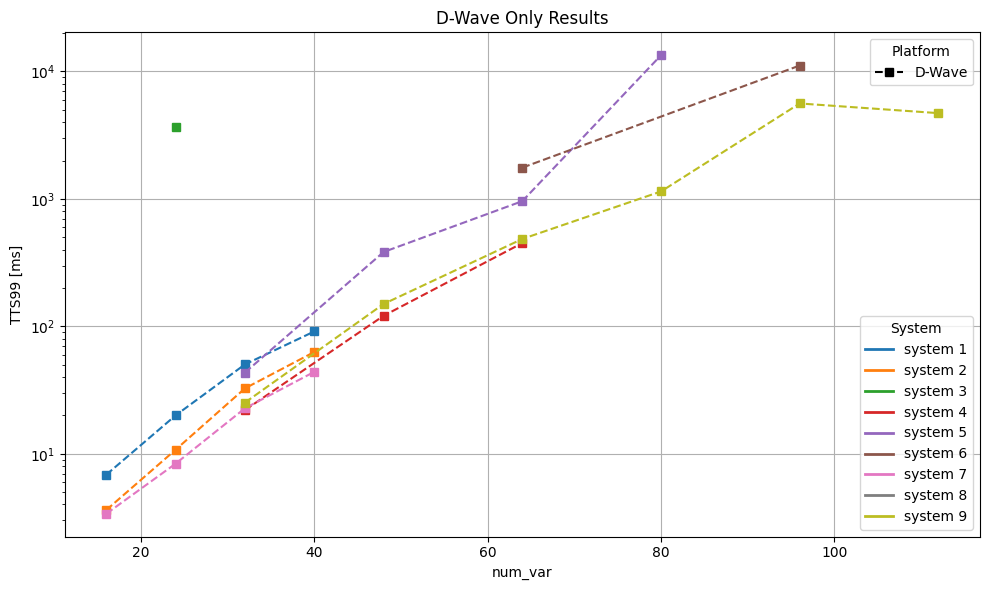

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
from    lib.lines import Line2D

for idx, system in enumerate(systems):
    # Tylko D-Wave
    df2_filtered = helpers.get_dwave_success_rates(system=system)
    df2_filtered['source'] = 'DWAVE'
    df2_filtered = df2_filtered.reset_index()
    df2_filtered['system'] = system
    df2_filtered['x_label'] = df2_filtered['precision'].astype(str) + '\n' + df2_filtered['timepoints'].astype(str)
    df2_filtered['tts99'] = df2_filtered.apply(lambda row: helpers.return_tts(row['success_prob'], row.runtime), axis=1)
    
    df = df2_filtered.dropna(subset=['num_var', 'tts99'])

    print(f'---------- System {system} ----------')
    print(df[['source', 'precision', 'num_var', 'timepoints', 'runtime', 'success_prob', 'tts99']])

    color = colors[idx % len(colors)]
    ax.plot(df['num_var'], df['tts99'],
            marker='s', linestyle='--', color=color, label=f'system {system}')

# Legenda: kolory / systemy
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=f'system {s}') for idx, s in enumerate(systems)
]

# Styl D-Wave tylko
style_legend = [
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='D-Wave')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')
legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1)

# Oś, tytuł itd.
ax.set_xlabel('num_var')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
ax.set_title('D-Wave Only Results')
plt.tight_layout()
plt.show()


## Success rates

In [ ]:
import matplotlib.font_manager as fm
markers = ['-o', '-s', '-^', '-D']  # 4 different markers
fm.fontManager.addfont("../times.ttf")  #path to the times.ttf file on your computer
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['Times New Roman'],
})

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'font.size': 12})

In [ ]:
df = helpers.get_dwave_success_rates(4, ta=200,grouped=False)
def calculate_percentile(group, percentile):
    return np.percentile(group, percentile)

# Calculate the 25th, 50th, and 90th percentiles
percentiles = df.groupby(['precision','timepoints','topology'])['success_prob'].agg(
    percentile_25=lambda x: calculate_percentile(x,50)-calculate_percentile(x, 25),
    percentile_50=lambda x: calculate_percentile(x, 50),  # Median
    percentile_75=lambda x: calculate_percentile(x, 75)-calculate_percentile(x,50)
)
percentiles

percentile_25  percentile_50  percentile_75
precision timepoints topology                                             
2         2          6.4               0.012          0.051          0.032
          3          6.4               0.004          0.010          0.003
          4          6.4               0.002          0.003          0.002
          5          6.4               0.000          0.000          0.000

{200: [0.0905609756097561, 0.03738888888888889]}


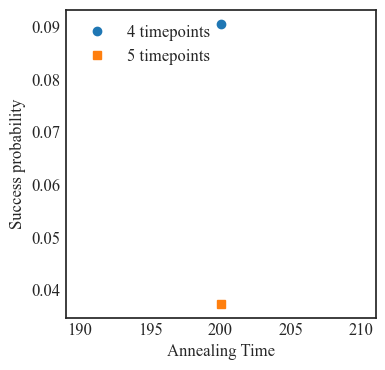

In [ ]:

system = 6
df_dict = {}
for ta in [200]:
    df = helpers.get_dwave_success_rates(system, topology="1.4",ta=ta,grouped=True)
    df = df[df['timepoints'].isin([4, 5])]
    df_dict[ta] = list(df['success_prob'])
    tp_list = list(df['timepoints'])

tp_list=[f"{i} timepoints" for i in tp_list]
print(df_dict)
df_ta = pd.DataFrame.from_dict(df_dict).transpose().set_axis(tp_list,axis=1)
ax = df_ta.plot(style=markers,  figsize=(4, 4))  # plot the dataframe and set Time as x
fig =ax.get_figure()
ax.set_xlabel('Annealing Time')
ax.set_ylabel('Success probability')
ax.legend(loc='upper left')
plt.savefig(f'../plots/system_{system}_ta.pdf',bbox_inches='tight')

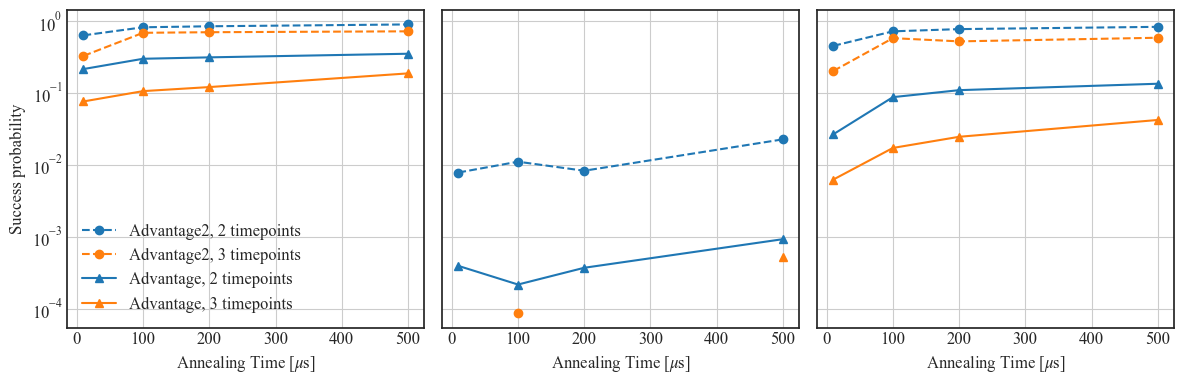

In [ ]:
import pandas as pd

annealing_times = [10,100,200,500]
timepoints_of_interest = [2, 3]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
systems = [2,3,9]

# przygotowanie figure z dwoma subplotami
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
colors = {2: 'tab:blue', 3: 'tab:orange'}
linestyles = {'1.4': 'dashed', '6.4': 'solid'}
markers = {'1.4': 'o', '6.4': '^'}
titles = {2: rf'$\left| \Psi_{system} \right\rangle$', 9: '^'}


for ax, system in zip(axes, systems):
    data = {tp: {t: [] for t in timepoints_of_interest} for tp in topologies}

    for topology in topologies:
        for ta in annealing_times:
            df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True)
            df = df[df['timepoints'].isin(timepoints_of_interest)]
            for tp in timepoints_of_interest:
                val = df[df['timepoints'] == tp]['success_prob'].values
                data[topology][tp].append(val[0] if len(val) > 0 else None)

    for topology in topologies:
        for tp in timepoints_of_interest:
            tas = [ta for i,ta in enumerate(annealing_times) if data[topology][tp][i] >0 ]
            data[topology][tp] = [p for p in data[topology][tp] if p >0]
            ax.plot(
                tas,
                data[topology][tp],
                label=f'{solver_names[topology]}, {tp} timepoints',
                color=colors[tp],
                linestyle=linestyles[topology],
                marker=markers[topology]
            )

    #ax.set_title(rf'$\widehat K_{system}$')
    ax.set_xlabel(r'Annealing Time [$\mu$s]')
    ax.set_yscale('log')
    ax.grid(True)

axes[0].set_ylabel('Success probability')
axes[0].legend(loc='lower left', fontsize=12)
plt.tight_layout()
plt.savefig(f'../plots/system_2_9_ta.pdf',bbox_inches='tight')
plt.show()


In [44]:
import pandas as pd


annealing_times = [10,100,200,500]
timepoints_of_interest = [2]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
native_systems = [1,2,5,6,7,9]
not_native_systems = [3,8]

ratio_dfs = []


for systems in [native_systems, not_native_systems]:
    dfs =[]
    for system in systems:
        for topology in topologies:
            for ta in annealing_times:
                df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True)
                df = df[df['timepoints'].isin(timepoints_of_interest)]
                df['system'] = system
                df['ta'] = ta
                dfs.append(df)

    combined_df = pd.concat(dfs)
    combined_df = combined_df[['topology','success_prob','ta']].groupby(by=['topology','ta']).mean()
    df_reset = combined_df.reset_index()

    df_14 = df_reset[df_reset['topology'] == '1.4'].set_index('ta')[['success_prob']]
    df_64 = df_reset[df_reset['topology'] == '6.4'].set_index('ta')[['success_prob']]
    ratio_dfs.append(df_14 / df_64)


In [52]:
ratio_df = ratio_dfs[0].copy()
ratio_df['p_ratio_non_native'] = ratio_dfs[1]['success_prob'].copy() 
ratio_df=ratio_df.rename({'success_prob':'p_ratio_native'},axis=1)
print(ratio_df.to_latex())

\begin{tabular}{lrr}
\toprule
 & p_ratio_native & p_ratio_non_native \\
ta &  &  \\
\midrule
10 & 5.240761 & 19.882828 \\
100 & 4.628113 & 51.031250 \\
200 & 4.045027 & 22.351648 \\
500 & 3.733719 & 24.429150 \\
\bottomrule
\end{tabular}



,success_prob
ta,
10,19.882828
100,51.031250
200,22.351648
500,24.429150


In [54]:
inst.draw({'edges':edges})

AttributeError: 'list' object has no attribute 'items'